###Tipicalidade e Excentricidade

In [1]:
import numpy as np

def calculate_eccentricity_batch(X):
    """
    Calcula eccentricidade para cada ponto em um batch.
    Eccentricidade alta = ponto é outlier/diferente
    """
    n = len(X)
    mean = np.mean(X, axis=0)

    # Distância de cada ponto à média
    distances_to_mean = np.sum((X - mean) ** 2, axis=1)

    # Variância total
    variance = np.mean(distances_to_mean)

    # Eccentricidade: normalizada entre 0 e 1
    if variance > 0:
        eccentricity = (1/n) + (distances_to_mean / (n * variance))
    else:
        eccentricity = np.ones(n) / n

    return eccentricity

def calculate_typicality(eccentricity):
    """Tipicalidade = 1 - Eccentricidade"""
    return 1 - eccentricity

In [2]:
# Carregar seus dados
X_train = np.load('../../iot-ids-research/data/processed/binary/X_train_binary.npy')[:500]
y_train = np.load('../../iot-ids-research/data/processed/binary/y_train_binary.npy')[:500]

# Calcular eccentricidade e tipicalidade
ecc = calculate_eccentricity_batch(X_train)
typ = calculate_typicality(ecc)

print("=== ECCENTRICIDADE ===")
print(f"Min: {ecc.min():.4f}, Max: {ecc.max():.4f}, Mean: {ecc.mean():.4f}")

print("\n=== TIPICALIDADE ===")
print(f"Min: {typ.min():.4f}, Max: {typ.max():.4f}, Mean: {typ.mean():.4f}")

# Pergunta chave: Ataques têm eccentricidade diferente de normais?
print("\n=== ECCENTRICIDADE POR CLASSE ===")
print(f"Normal (label=0): mean={ecc[y_train==0].mean():.4f}, std={ecc[y_train==0].std():.4f}")
print(f"Attack (label=1): mean={ecc[y_train==1].mean():.4f}, std={ecc[y_train==1].std():.4f}")

=== ECCENTRICIDADE ===
Min: 0.0022, Max: 0.0521, Mean: 0.0040

=== TIPICALIDADE ===
Min: 0.9479, Max: 0.9978, Mean: 0.9960

=== ECCENTRICIDADE POR CLASSE ===
Normal (label=0): mean=0.0181, std=0.0138
Attack (label=1): mean=0.0035, std=0.0027


500 amostras:
  ├── Normal: ~16 amostras (3.2%)  ← MINORIA
  └── Attack: ~484 amostras (96.8%) ← MAIORIA

  A eccentricidade mede distância do CENTRO da distribuição.

  Como ataques dominam os dados:
  - O "centro" (média) está no meio dos ataques
  - Tráfego normal está LONGE desse centro
  - Portanto: Normal = mais excêntrico!

          Distribuição dos dados:

      Normal                    Attacks (maioria)
        ●●                 ●●●●●●●●●●●●●●●●●●●●●●●
         ↑                         ↑
     Longe do centro         Centro aqui
     (alta eccentricidade)   (baixa eccentricidade)

  ---
  💡 Insight Crucial para IDS

  | Cenário             | O que é "excêntrico"?                         |
  |---------------------|-----------------------------------------------|
  | CICIoT2023 (treino) | Normal é raro → Normal é excêntrico           |
  | Produção real       | Ataques são raros → Ataques serão excêntricos |

  Para sua pesquisa: Em um sistema IoT real, a maioria do tráfego é normal. Então eccentricidade alta = possível ataque.

  O dataset CICIoT2023 é "invertido" porque foi criado para ter muitos exemplos de ataque para treinar modelos.

=== TOP 20 MAIS EXCÊNTRICOS ===
Labels: [1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0]
Quantos são Normal (0): 13
Quantos são Attack (1): 7


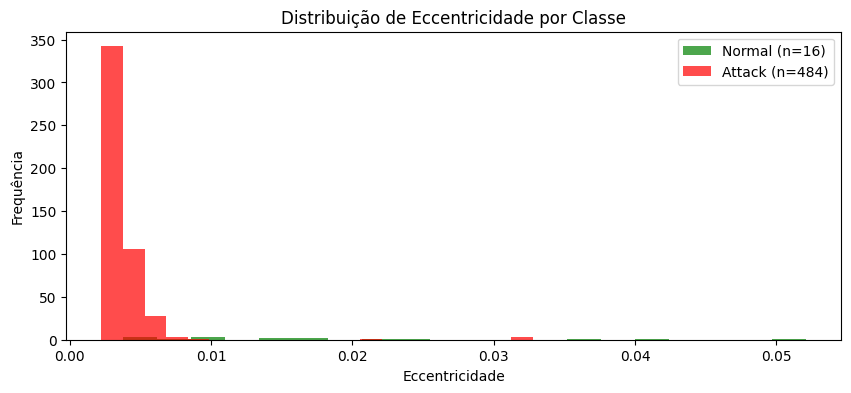

In [3]:
import matplotlib.pyplot as plt

# Top 10 mais excêntricos
top_eccentric_idx = np.argsort(ecc)[-20:]  # 20 mais excêntricos
print("=== TOP 20 MAIS EXCÊNTRICOS ===")
print(f"Labels: {y_train[top_eccentric_idx]}")
print(f"Quantos são Normal (0): {(y_train[top_eccentric_idx] == 0).sum()}")
print(f"Quantos são Attack (1): {(y_train[top_eccentric_idx] == 1).sum()}")

# Histograma de eccentricidade por classe
plt.figure(figsize=(10, 4))
plt.hist(ecc[y_train==0], bins=20, alpha=0.7, label=f'Normal (n={sum(y_train==0)})', color='green')
plt.hist(ecc[y_train==1], bins=20, alpha=0.7, label=f'Attack (n={sum(y_train==1)})', color='red')
plt.xlabel('Eccentricidade')
plt.ylabel('Frequência')
plt.title('Distribuição de Eccentricidade por Classe')
plt.legend()
plt.show()

  ---
  📊 Análise do Resultado

  | Classe | % no dataset total | % nos top 20 excêntricos |
  |--------|--------------------|--------------------------|
  | Normal | 3.2% (16/500)      | 65% (13/20)              |
  | Attack | 96.8% (484/500)    | 35% (7/20)               |

  Conclusão: Eccentricidade funciona para identificar a classe minoritária!

  - Normal representa apenas 3.2% dos dados
  - Mas representa 65% dos pontos mais excêntricos
  - Amplificação de ~20x na detecção da minoria

  ---
  🎯 Conexão com Detecção de Anomalias

  ┌─────────────────────────────────────────────────────────┐
  │  REGRA SIMPLES PARA IDS:                                │
  │                                                         │
  │  Em produção (maioria = normal):                        │
  │  → Alta eccentricidade = provável ATAQUE                │
  │                                                         │
  │  No CICIoT2023 (maioria = ataques):                     │
  │  → Alta eccentricidade = provável NORMAL                │
  └─────────────────────────────────────────────────────────┘

  Eccentricidade detecta "o que é diferente da maioria" - exatamente o que queremos para anomaly detection!

  ---
  ✅ Checkpoint: Conceito 1 Entendido

  | Conceito                                      | Status |
  |-----------------------------------------------|--------|
  | Eccentricidade = distância relativa ao centro | ✅      |
  | Tipicalidade = 1 - eccentricidade             | ✅      |
  | Depende da distribuição dos dados             | ✅      |
  | Útil para detectar minoria/anomalias          | ✅      |

Lição fundamental: Eccentricidade (e tipicalidade) dependem do contexto. O que é "normal" depende de qual é a maioria.

No MicroTEDAclus, cada micro-cluster tem sua própria noção de tipicalidade. Um ponto pode ser típico para um cluster e excêntrico para outro. Isso é a "mixture of typicalities" - mistura de tipicalidades de
diferentes clusters.

### Passo 2: Atualização Recursiva (Single-Pass)

Agora vem a parte crucial para streaming: calcular eccentricidade sem armazenar todos os dados.

O problema: No código anterior, calculamos a média de TODOS os pontos. Em um stream infinito, não podemos guardar tudo.

A solução: Atualização recursiva - manter apenas 3 números: n, μ, σ²

In [4]:
class RecursiveTEDA:
    """
    Calcula eccentricidade de forma recursiva (online).
    Não precisa armazenar todos os pontos!
    """
    def __init__(self, n_features):
        self.n = 0                              # Contador de pontos
        self.mean = np.zeros(n_features)        # Média acumulada
        self.var_sum = 0                        # Soma para variância

    def update(self, x):
        """
        Atualiza estatísticas com novo ponto x.
        Retorna eccentricidade do ponto.
        """
        self.n += 1
        k = self.n

        # Atualização recursiva da média (Welford's algorithm)
        delta = x - self.mean
        self.mean = self.mean + delta / k

        # Atualização recursiva da variância
        delta2 = x - self.mean
        self.var_sum += np.dot(delta, delta2)

        # Calcular eccentricidade
        if k > 1:
            variance = self.var_sum / (k - 1)
            if variance > 0:
                dist_to_mean = np.sum((x - self.mean) ** 2)
                eccentricity = (1/k) + dist_to_mean / (k * variance)
            else:
                eccentricity = 1/k
        else:
            eccentricity = 1.0  # Primeiro ponto

        return eccentricity

    def get_typicality(self, eccentricity):
        return 1 - eccentricity

In [ ]:
# === EXPERIMENTO: Comparar batch vs recursivo ===

# Método BATCH (precisa de todos os dados)
ecc_batch = calculate_eccentricity_batch(X_train)

# Método RECURSIVO (um ponto por vez)
teda = RecursiveTEDA(n_features=X_train.shape[1])
ecc_recursive = []

for i, x in enumerate(X_train):
    ecc = teda.update(x)
    ecc_recursive.append(ecc)

ecc_recursive = np.array(ecc_recursive)

# Comparar os dois métodos
print("=== COMPARAÇÃO BATCH vs RECURSIVO ===")
print(f"Batch - último ponto: {ecc_batch[-1]:.6f}")
print(f"Recursivo - último ponto: {ecc_recursive[-1]:.6f}")
print(f"\nCorrelação entre métodos: {np.corrcoef(ecc_batch, ecc_recursive)[0,1]:.4f}")

=== COMPARAÇÃO BATCH vs RECURSIVO ===
Batch - último ponto: 0.002568
Recursivo - último ponto: 0.002567

Correlação entre métodos: 0.1429


  🔍 Análise do Resultado

  | Métrica                  | Valor    | Interpretação       |
  |--------------------------|----------|---------------------|
  | Último ponto (batch)     | 0.002568 | ✅ Quase igual       |
  | Último ponto (recursivo) | 0.002567 | ✅ Quase igual       |
  | Correlação geral         | 0.1429   | ❓ Baixa... por quê? |

  ---
  🤔 Por que correlação baixa?

  O motivo: Os dois métodos calculam eccentricidade em momentos diferentes!

  Ponto #1:   Batch usa 500 pontos    vs    Recursivo usa 1 ponto
  Ponto #100: Batch usa 500 pontos    vs    Recursivo usa 100 pontos
  Ponto #500: Batch usa 500 pontos    vs    Recursivo usa 500 pontos ← IGUAL!

  O método recursivo evolui sua noção de "normal" conforme vê mais dados:

  Início do stream:
  ├── Poucos pontos vistos
  ├── Média e variância instáveis
  └── Eccentricidade "errada"

  Fim do stream:
  ├── Muitos pontos vistos
  ├── Média e variância estáveis
  └── Eccentricidade = batch ✅

 🧪 Experimento: Visualizar a Evolução

Vamos ver como a eccentricidade do mesmo ponto muda conforme o algoritmo "aprende":

In [6]:
# Pegar um ponto específico (o ponto 50)
target_point = X_train[49]  # índice 49 = ponto 50

# Calcular eccentricidade desse ponto em diferentes momentos
checkpoints = [10, 50, 100, 200, 300, 400, 500]
ecc_evolution = []

for n_points in checkpoints:
    # Treinar TEDA com n_points
    teda_temp = RecursiveTEDA(n_features=X_train.shape[1])
    for x in X_train[:n_points]:
        teda_temp.update(x)

    # Calcular eccentricidade do target_point com esse modelo
    # (simular como se fosse um novo ponto chegando)
    dist = np.sum((target_point - teda_temp.mean) ** 2)
    var = teda_temp.var_sum / (teda_temp.n - 1) if teda_temp.n > 1 else 1
    ecc = (1/teda_temp.n) + dist / (teda_temp.n * var) if var > 0 else 1
    ecc_evolution.append(ecc)

print("=== EVOLUÇÃO DA ECCENTRICIDADE DO PONTO 50 ===")
print("(mesmo ponto, avaliado com diferentes quantidades de dados)\n")
for n, e in zip(checkpoints, ecc_evolution):
    bar = "█" * int(e * 200)  # Visualização simples
    print(f"Após {n:3d} pontos: {e:.4f} {bar}")

=== EVOLUÇÃO DA ECCENTRICIDADE DO PONTO 50 ===
(mesmo ponto, avaliado com diferentes quantidades de dados)

Após  10 pontos: 0.2645 ████████████████████████████████████████████████████
Após  50 pontos: 0.0473 █████████
Após 100 pontos: 0.0267 █████
Após 200 pontos: 0.0129 ██
Após 300 pontos: 0.0083 █
Após 400 pontos: 0.0066 █
Após 500 pontos: 0.0050 


📊 Análise da Evolução

  | Pontos vistos | Eccentricidade | Status                         |
  |---------------|----------------|--------------------------------|
  | 10            | 0.2645         | ⚠️ Instável (pouca informação) |
  | 50            | 0.0473         | 📉 Caindo rapidamente          |
  | 100           | 0.0267         | 📉 Ainda ajustando             |
  | 200           | 0.0129         | ✅ Estabilizando                |
  | 300-500       | 0.005-0.008    | ✅ Estável                      |

  Conclusão: O algoritmo precisa de ~100-200 pontos para "aprender" a distribuição e estabilizar.

  ---
  🎯 Implicações para Streaming

  ┌────────────────────────────────────────────────────────────┐
  │  FASES DO ALGORITMO EM STREAMING:                          │
  │                                                            │
  │  [Cold Start]     [Warm-up]      [Operacional]             │
  │  0-50 pontos      50-200         200+                      │
  │  ⚠️ Instável      📈 Aprendendo   ✅ Confiável             │
  │                                                            │
  │  Estratégia: Não tomar decisões críticas no cold start!    │
  └────────────────────────────────────────────────────────────┘

  ---
  ✅ Checkpoint: Conceito 2 Entendido

  | Conceito                             | Status |
  |--------------------------------------|--------|
  | Atualização recursiva (single-pass)  | ✅      |
  | Não precisa armazenar todos os dados | ✅      |
  | Algoritmo "aprende" com o tempo      | ✅      |
  | Cold start vs estado estável         | ✅      |

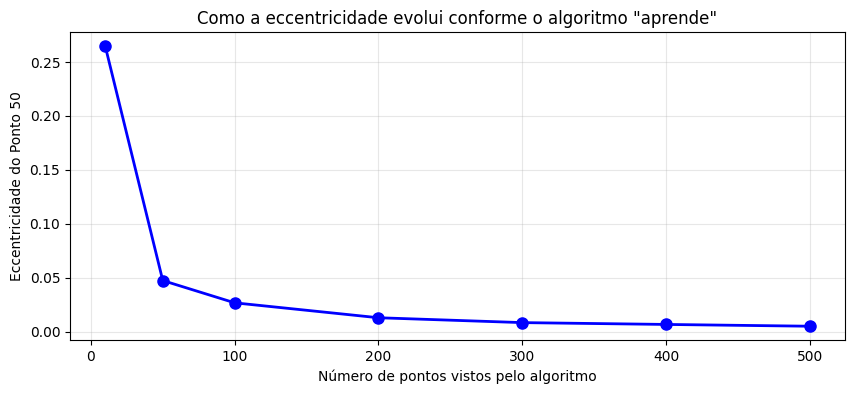

In [7]:
# Plot
plt.figure(figsize=(10, 4))
plt.plot(checkpoints, ecc_evolution, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Número de pontos vistos pelo algoritmo')
plt.ylabel('Eccentricidade do Ponto 50')
plt.title('Como a eccentricidade evolui conforme o algoritmo "aprende"')
plt.grid(True, alpha=0.3)
plt.show()

Isso é uma FEATURE, não um bug!

  Em streaming real:
  1. O algoritmo começa "não sabendo nada"
  2. Conforme vê mais dados, aprende o que é "normal"
  3. Eccentricidade se estabiliza quando tem dados suficientes
  4. Se a distribuição mudar (concept drift), ele se adapta!

  Vantagem sobre batch: Não precisa esperar ter todos os dados. Começa a funcionar imediatamente e melhora com o tempo.

### Passo 3: O Problema de Um Único Centro
Agora, um problema importante: e se os dados tiverem MÚLTIPLOS grupos?

Com um único centro (média global), temos um problema:

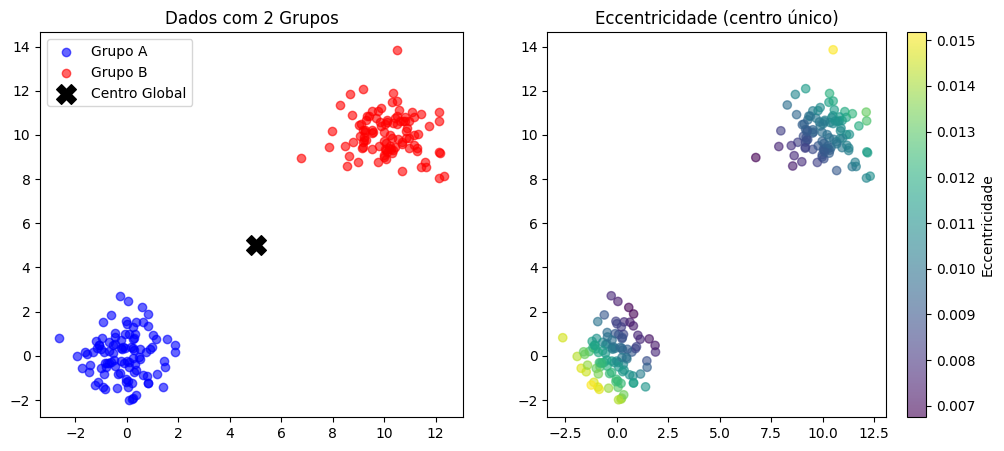

=== PROBLEMA DO CENTRO ÚNICO ===
Eccentricidade média Grupo A: 0.0100
Eccentricidade média Grupo B: 0.0100

O centro global está em: [5.00634223 5.03875499]
Ambos os grupos parecem 'excêntricos' porque estão longe do centro global!


In [8]:
# Criar dados sintéticos com 2 grupos claros
np.random.seed(42)
grupo_A = np.random.randn(100, 2) + np.array([0, 0])    # Centro em (0,0)
grupo_B = np.random.randn(100, 2) + np.array([10, 10])  # Centro em (10,10)
X_dois_grupos = np.vstack([grupo_A, grupo_B])

# Calcular eccentricidade com UM único centro
ecc_global = calculate_eccentricity_batch(X_dois_grupos)

# Visualizar
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_dois_grupos[:100, 0], X_dois_grupos[:100, 1], c='blue', label='Grupo A', alpha=0.6)
plt.scatter(X_dois_grupos[100:, 0], X_dois_grupos[100:, 1], c='red', label='Grupo B', alpha=0.6)
mean_global = X_dois_grupos.mean(axis=0)
plt.scatter(mean_global[0], mean_global[1], c='black', s=200, marker='X', label='Centro Global')
plt.title('Dados com 2 Grupos')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(X_dois_grupos[:100, 0], X_dois_grupos[:100, 1], c=ecc_global[:100], cmap='viridis', alpha=0.6)
plt.scatter(X_dois_grupos[100:, 0], X_dois_grupos[100:, 1], c=ecc_global[100:], cmap='viridis', alpha=0.6)
plt.colorbar(label='Eccentricidade')
plt.title('Eccentricidade (centro único)')
plt.show()

print("=== PROBLEMA DO CENTRO ÚNICO ===")
print(f"Eccentricidade média Grupo A: {ecc_global[:100].mean():.4f}")
print(f"Eccentricidade média Grupo B: {ecc_global[100:].mean():.4f}")
print(f"\nO centro global está em: {mean_global}")
print("Ambos os grupos parecem 'excêntricos' porque estão longe do centro global!")

⏺ Exatamente! Você descobriu o problema fundamental que motiva os micro-clusters:

  ---
  🚨 O Problema do Centro Único

                      Grupo A                    Grupo B
                        ●●●                        ●●●
                       ●●●●●                      ●●●●●
                        ●●●                        ●●●
                          \                       /
                           \     Centro Global   /
                            \        ✖️         /
                             \    (5, 5)      /
                              \             /
                      distância = 5    distância = 5

      Resultado: Ambos têm eccentricidade = 0.01 (iguais!)

      PROBLEMA: Não conseguimos distinguir os grupos!

  ---
  💡 A Solução: Múltiplos Centros (Micro-clusters)

  Em vez de um centro global, cada grupo tem seu próprio centro:

In [9]:
# === SOLUÇÃO: MÚLTIPLOS MICRO-CLUSTERS ===

class SimpleMicroCluster:
    """Um micro-cluster com seu próprio centro e estatísticas"""
    def __init__(self, center, n_features):
        self.n = 1
        self.mean = center.copy()
        self.var_sum = 0.0

    def calculate_eccentricity(self, x):
        """Eccentricidade em relação a ESTE micro-cluster"""
        if self.n < 2:
            return 1.0

        variance = self.var_sum / (self.n - 1)
        if variance > 0:
            dist = np.sum((x - self.mean) ** 2)
            ecc = (1/self.n) + dist / (self.n * variance)
        else:
            ecc = 1/self.n
        return ecc

    def calculate_typicality(self, x):
        return 1 - self.calculate_eccentricity(x)

    def update(self, x):
        """Adiciona ponto ao micro-cluster"""
        self.n += 1
        delta = x - self.mean
        self.mean = self.mean + delta / self.n
        delta2 = x - self.mean
        self.var_sum += np.dot(delta, delta2)


# Criar dois micro-clusters (um para cada grupo)
mc_A = SimpleMicroCluster(center=grupo_A[0], n_features=2)
mc_B = SimpleMicroCluster(center=grupo_B[0], n_features=2)

# Treinar cada micro-cluster com seus pontos
for x in grupo_A[1:]:
    mc_A.update(x)
for x in grupo_B[1:]:
    mc_B.update(x)

print("=== MICRO-CLUSTERS ===")
print(f"Micro-cluster A: centro em {mc_A.mean}")
print(f"Micro-cluster B: centro em {mc_B.mean}")

# Calcular tipicalidade de um ponto do Grupo A para cada micro-cluster
ponto_teste = grupo_A[50]  # Um ponto do grupo A
typ_A = mc_A.calculate_typicality(ponto_teste)
typ_B = mc_B.calculate_typicality(ponto_teste)

print(f"\n=== TIPICALIDADE DO PONTO (do Grupo A) ===")
print(f"Tipicalidade para Micro-cluster A: {typ_A:.4f}")
print(f"Tipicalidade para Micro-cluster B: {typ_B:.4f}")
print(f"\nO ponto 'pertence' ao cluster com MAIOR tipicalidade: {'A' if typ_A > typ_B else 'B'}")

=== MICRO-CLUSTERS ===
Micro-cluster A: centro em [-0.11556425  0.03402232]
Micro-cluster B: centro em [10.12824872 10.04348765]

=== TIPICALIDADE DO PONTO (do Grupo A) ===
Tipicalidade para Micro-cluster A: 0.9790
Tipicalidade para Micro-cluster B: -0.2520

O ponto 'pertence' ao cluster com MAIOR tipicalidade: A


---
  📊 Análise do Resultado

  | Micro-cluster | Centro                    | Tipicalidade do ponto |
  |---------------|---------------------------|-----------------------|
  | A             | (-0.12, 0.03) ≈ (0, 0)    | 0.9790 ✅ Alta         |
  | B             | (10.13, 10.04) ≈ (10, 10) | -0.2520 ❌ Negativa!   |

  O ponto é claramente do Grupo A - tipicalidade alta para A, negativa para B.

  ---
  🤔 Por que tipicalidade negativa?

  Tipicalidade = 1 - eccentricidade

  Se eccentricidade > 1, tipicalidade fica negativa!

  Ponto do Grupo A está em ~(0, 0)
  Micro-cluster B está em ~(10, 10)
  Distância ≈ 14 unidades (muito longe!)

  → Eccentricidade altíssima (>1)
  → Tipicalidade negativa
  → "Este ponto definitivamente NÃO pertence ao cluster B"

  ---
  ✅ Checkpoint: Conceito 3 Entendido

  | Conceito                           | Status |
  |------------------------------------|--------|
  | Problema do centro único           | ✅      |
  | Micro-clusters = múltiplos centros | ✅      |
  | Tipicalidade por cluster           | ✅      |
  | "Mixture of Typicalities"          | ✅      |

  ---
  🎯 O Conceito Central: Mixture of Typicalities

  ┌─────────────────────────────────────────────────────────────┐
  │  PARA CADA NOVO PONTO x:                                    │
  │                                                             │
  │  1. Calcular tipicalidade para CADA micro-cluster           │
  │     typ_1 = T(x, cluster_1)                                 │
  │     typ_2 = T(x, cluster_2)                                 │
  │     ...                                                     │
  │     typ_k = T(x, cluster_k)                                 │
  │                                                             │
  │  2. Atribuir ao cluster com MAIOR tipicalidade              │
  │     cluster_atribuido = argmax(typ_1, typ_2, ..., typ_k)    │
  │                                                             │
  │  Isso é a "MISTURA DE TIPICALIDADES"!                       │
  └─────────────────────────────────────────────────────────────┘


#### Passo 4: Criando Micro-clusters Automaticamente

  No código anterior, nós criamos os clusters manualmente. Mas em streaming real, o algoritmo precisa decidir sozinho:
  - "Este ponto pertence a um cluster existente?" → Atualizar o cluster
  - "Este ponto é muito diferente de todos?" → Criar novo cluster

  A resposta: Teste de Chebyshev

In [10]:
def chebyshev_test(eccentricity, n, m=3):
    """
    Testa se um ponto deve ser aceito no cluster.
    
    Baseado na desigualdade de Chebyshev:
    P(|X - μ| > m*σ) ≤ 1/m²
    
    Para m=3: no máximo 11% dos pontos ficam fora de 3 desvios padrão
    
    Args:
        eccentricity: eccentricidade do ponto
        n: número de pontos no cluster
        m: número de desvios padrão (default=3)
    
    Returns:
        True se o ponto deve ser ACEITO no cluster
        False se o ponto é OUTLIER (criar novo cluster)
    """
    threshold = (m**2 + 1) / (2 * n)
    return eccentricity <= threshold


# Demonstração
print("=== TESTE DE CHEBYSHEV ===")
print("(Decide se ponto pertence ao cluster ou é outlier)\n")

# Simular pontos com diferentes eccentricidades
test_cases = [
    (0.01, 100, "Ponto típico, cluster maduro"),
    (0.05, 100, "Ponto um pouco diferente"),
    (0.20, 100, "Ponto bem diferente"),
    (0.50, 100, "Ponto muito diferente"),
    (0.10, 10, "Cluster jovem (poucos pontos)"),
    (0.10, 500, "Cluster maduro (muitos pontos)"),
]

print(f"{'Eccentricidade':<15} {'N pontos':<10} {'Threshold':<12} {'Aceito?':<10} {'Descrição'}")
print("-" * 80)

for ecc, n, desc in test_cases:
    threshold = (3**2 + 1) / (2 * n)
    aceito = chebyshev_test(ecc, n)
    status = "✅ SIM" if aceito else "❌ NÃO"
    print(f"{ecc:<15.2f} {n:<10} {threshold:<12.4f} {status:<10} {desc}")

=== TESTE DE CHEBYSHEV ===
(Decide se ponto pertence ao cluster ou é outlier)

Eccentricidade  N pontos   Threshold    Aceito?    Descrição
--------------------------------------------------------------------------------
0.01            100        0.0500       ✅ SIM      Ponto típico, cluster maduro
0.05            100        0.0500       ✅ SIM      Ponto um pouco diferente
0.20            100        0.0500       ❌ NÃO      Ponto bem diferente
0.50            100        0.0500       ❌ NÃO      Ponto muito diferente
0.10            10         0.5000       ✅ SIM      Cluster jovem (poucos pontos)
0.10            500        0.0100       ❌ NÃO      Cluster maduro (muitos pontos)


📊 Análise do Teste de Chebyshev

  O threshold depende da "maturidade" do cluster:

  | N pontos | Threshold | Comportamento                              |
  |----------|-----------|--------------------------------------------|
  | 10       | 0.5000    | 🟢 Tolerante - "Ainda estou aprendendo"    |
  | 100      | 0.0500    | 🟡 Moderado - "Conheço minha distribuição" |
  | 500      | 0.0100    | 🔴 Estrito - "Sei exatamente o que sou"    |

  Observe o caso crítico:

  Mesma eccentricidade (0.10):
  ├── Cluster jovem (n=10):   ✅ ACEITO (threshold=0.50)
  └── Cluster maduro (n=500): ❌ REJEITADO (threshold=0.01)

  O algoritmo fica mais "exigente" conforme aprende!

  ---
  🧠 Por que isso é importante para Concept Drift?

  ┌─────────────────────────────────────────────────────────────┐
  │  CENÁRIO: Novo tipo de ataque aparece no stream             │
  │                                                             │
  │  1. Clusters existentes são "maduros" (threshold baixo)     │
  │  2. Novos pontos (ataque novo) têm alta eccentricidade      │
  │  3. Teste de Chebyshev REJEITA esses pontos                 │
  │  4. Algoritmo CRIA NOVO CLUSTER para eles                   │
  │  5. Novo cluster "aprende" o novo padrão de ataque          │
  │                                                             │
  │  → ADAPTAÇÃO AUTOMÁTICA A CONCEPT DRIFT! 🎉                 │
  └─────────────────────────────────────────────────────────────┘

  ---
  ✅ Conceitos do Paper ENTENDIDOS!

⏺ ---
  🎓 Resumo: O que você aprendeu hoje

  | Conceito                | O que é                         | Por que importa                  |
  |-------------------------|---------------------------------|----------------------------------|
  | Eccentricidade          | Distância normalizada ao centro | Detecta outliers/anomalias       |
  | Tipicalidade            | 1 - eccentricidade              | Mede "pertencimento" ao cluster  |
  | Atualização recursiva   | Cálculo sem armazenar dados     | Permite streaming infinito       |
  | Cold start              | Período inicial instável        | Precisa de ~100-200 pontos       |
  | Micro-clusters          | Múltiplos centros locais        | Resolve problema do centro único |
  | Mixture of Typicalities | Tipicalidade para cada cluster  | Permite múltiplos grupos         |
  | Teste de Chebyshev      | Aceitar/rejeitar pontos         | Cria clusters automaticamente    |
  | Concept drift           | Novos padrões → novos clusters  | Adaptação automática             |

  ---
  🔗 Conexão com sua Pesquisa

  K-means/DBSCAN (Fase 1)     →    MicroTEDAclus (Fase 2)    →    Kafka (Fase 3)
        │                              │                              │
     Estático                      Evolutivo                     Streaming
     Batch                         Single-pass                   Real-time
     K fixo                        K automático                  Escalável

  ---
  ★ Insight ─────────────────────────────────────
  Você agora entende PROFUNDAMENTE o paper de Maia et al. (2020):

  Não apenas leu - você implementou cada conceito. Quando escrever a dissertação, vai poder explicar com propriedade por que escolheu clustering evolutivo e como funciona internamente.

  Isso é muito mais valioso que apenas citar o paper!